In [70]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from src.preprocessing import prepare_data
from src.utils import plot_forecast, calculate_ic
import seaborn as sns
sns.set_style("dark")
sns.set_palette("dark")

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from datetime import datetime, date

# Sarima

Em modelos regressivos temporais, como ARIMA, multicolinearidade pode causar problemas de estimativa instável dos coeficientes, especialmente quando muitas variáveis (ou "lags") estão presentes e são fortemente correlacionadas. Isso é chamado de "curse of dimensionality" e afeta a precisão da previsão, além de dificultar a interpretação dos coeficientes. O excesso de lags correlacionados também pode levar a overfitting, onde o modelo se ajusta muito bem ao histórico, mas perde capacidade de generalizar para dados futuros.

In [2]:
df = pd.read_csv("../data/jena_climate_2009_2016.csv")
df = prepare_data(df)
target = "temperature_celsius"
# considerando que toda base será usada para treino, exceto o último dia e não há nulos no último dia, o ffill é uma maneira rápida de preencher os nulos.
df.ffill(inplace=True)
df = df.set_index("date")
df.index = pd.DatetimeIndex(df.index.values,freq="h")
df.head()

,internal_pressure,temperature_celsius,dew_point,relative_humidity,saturation_vapor_pressure,vapor_pressure,vapor_pressure_deficit,specific_humidity,water_vapor_concentration,airtight,wind_speed,maximum_wind_speed,wind_direction_degree,days_since_beginning,year
2009-01-01 00:00:00,996.528000,-8.304000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000,0,2009
2009-01-01 01:00:00,996.525000,-8.065000,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667,0,2009
2009-01-01 02:00:00,996.745000,-8.763333,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667,0,2009
2009-01-01 03:00:00,996.986667,-8.896667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333,0,2009
2009-01-01 04:00:00,997.158333,-9.348333,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333,0,2009


## Autocorrelação e Autocorrelação Parcial

### ACF
ACF calcula a correlação entre as observações de uma série temporal com observações no passado, em lags diferentes, sem remover o efeito dos lags intermediários.

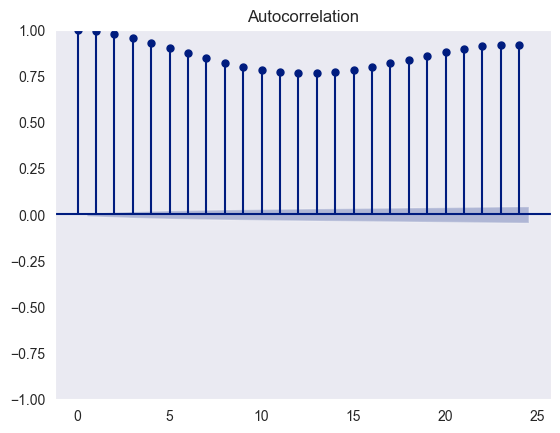

In [3]:
sm.graphics.tsa.plot_acf(df[target],lags = 24)
plt.show()

> Correlação alta em todos os lags:

A correlação para os primeiros 25 lags é alta e lentamente decrescente, permanecendo bem acima da linha de confiança.
Isso sugere uma forte autocorrelação persistente, indicando que o valor da temperatura atual está fortemente relacionado com os valores passados, mesmo para lags distantes.

> Decaimento lento:

O decaimento lento da autocorrelação sugere a presença de uma tendência ou sazonalidade na série. Para dados de temperatura, isso faz sentido, pois há um padrão sazonal (ex.: diário ou anual).

> Significância estatística:

A maioria das barras está fora das bandas de confiança (área sombreada). Isso significa que quase todos os lags exibidos são estatisticamente significativos, ou seja, há dependência serial na série temporal.

> Conclusão: Essa queda "lenta" da correlação, aliada ao resultado da Dickey-Fuller, indica fortemente a presença da sazonalidade e a necessidade de diferenciar a série para lidar com a não estacionaridade.

### PACF
A PACF, por outro lado, é usada para verificar a relação direta entre uma observação em um momento específico e seus valores defasados, enquanto remove efetivamente a influência de defasagens mais curtas. 
Isso significa que a PACF(x) fornece a correlação entre a série e ela mesma com defasagem de “x” períodos de tempo, depois de considerar a dependência linear da série em defasagens menores, isolando assim o efeito direto de uma defasagem específica.

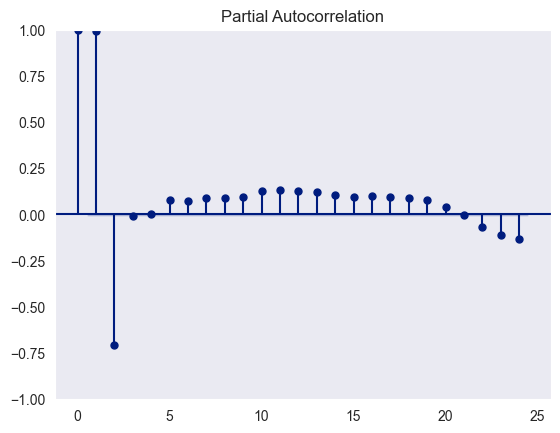

In [4]:
sm.graphics.tsa.plot_pacf(df[target],lags = 24)
plt.show()

> Lag 1 e Lag 2:

No seu gráfico, o coeficiente de correlação parcial é próximo de 1 para o lag 1 e próximo de -0.8 para o lag 2, indicando uma forte correlação (positiva e negativa, respectivamente).
Isso sugere que a série temporal possui uma dependência forte com seus valores imediatos passados.

> Lag 3 em diante:

Após o lag 2, a maioria dos coeficientes de correlação parcial estão próximos de zero.
Isso indica que, após o lag 2, não há uma dependência significativa direta que não seja explicada pelos lags anteriores.

> Conclusão:
O gráfico sugere que um modelo AR(2) pode ser adequado, pois os lags 1 e 2 têm uma correlação significativa, e os lags seguintes não.

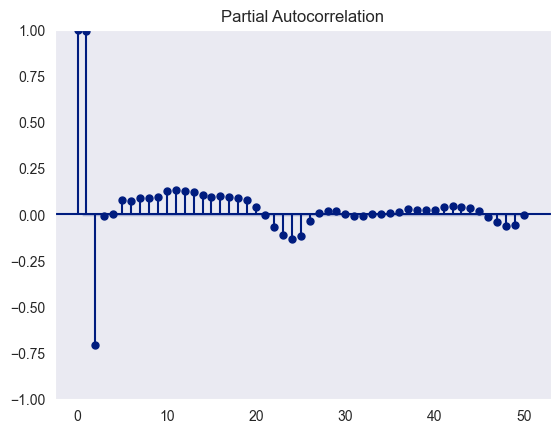

In [5]:
sm.graphics.tsa.plot_pacf(df[target],lags = 50)
plt.show()

Pelo PACF com mais lags (50h de lag), é possível ver que existe uma correlação com as horas 24 e, bem menos, com a 48h.

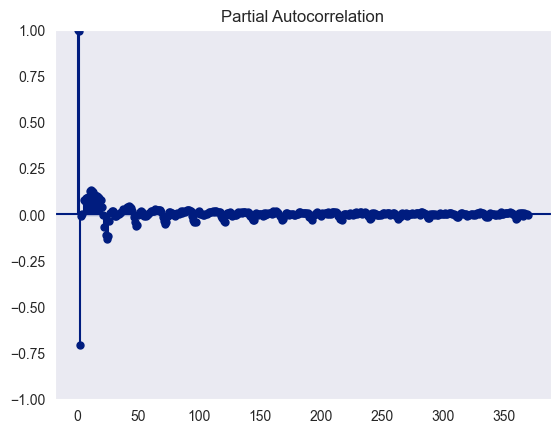

In [6]:
sm.graphics.tsa.plot_pacf(df[target],lags = 370)
plt.show()

## Sazonalidade

Uma forma de capturar sazonalidade é usando a função do `statsmodel`: `seasonal_decompose`. Ela retorna um objeto que contém os seguintes componentes:
1. Tendência: Esse componente reflete a progressão de longo prazo da série, destacando como a tendência central dos dados muda ao longo do tempo. É útil para identificar movimentos ascendentes ou descendentes na série durante longos períodos.
2. Sazonal: Esse componente captura o ciclo repetitivo de curto prazo nos dados. Ele representa as flutuações sazonais que ocorrem com uma frequência fixa e conhecida. Por exemplo, no contexto de dados mensais, isso poderia destacar o aumento das vendas durante a temporada de férias ou o aumento do consumo de energia durante o inverno e o verão.
3. Resid (Residual): O componente residual consiste no restante da série temporal depois que os componentes de tendência e sazonais foram removidos. Ele representa a parte irregular ou estocástica da série que não pode ser atribuída à tendência ou à sazonalidade. Isso pode incluir flutuações aleatórias ou ruído nos dados.


Sazonalidade Diária


<Figure size 2000x800 with 0 Axes>

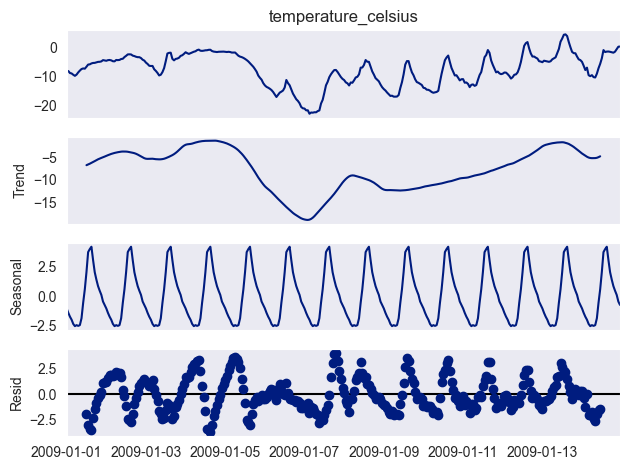

In [7]:
period = 24
n = 14
print("Sazonalidade Diária")
decomposition = seasonal_decompose(df[target].head(period*n), model='additive', period=period)
plt.figure(figsize=(20, 8))
decomposition.plot()
plt.show()

Sazonalidade Mensal


<Figure size 2000x800 with 0 Axes>

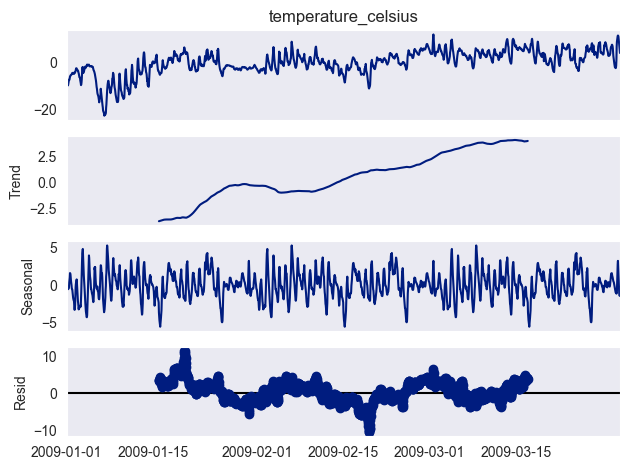

In [8]:
print("Sazonalidade Mensal")
period = 24*30
n = 3
decomposition = seasonal_decompose(df[target].head(period*n), model='additive', period=period)
plt.figure(figsize=(20, 8))
decomposition.plot()
plt.show()

Sazonalidade Anual


<Figure size 2000x800 with 0 Axes>

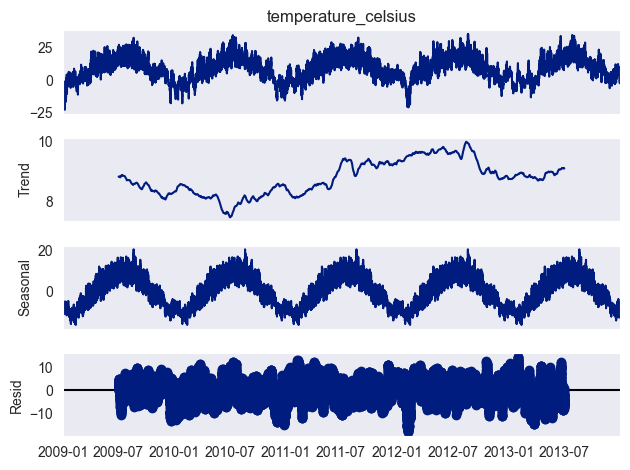

In [9]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
period = 24*365
n = 5
decomposition = seasonal_decompose(df[target].head(period*n), model='additive', period=period)
print("Sazonalidade Anual")
plt.figure(figsize=(20, 8))
decomposition.plot()
plt.show()

# Modelagem

Train Data Shape: (17544,)
Test Data Shape: (25,)


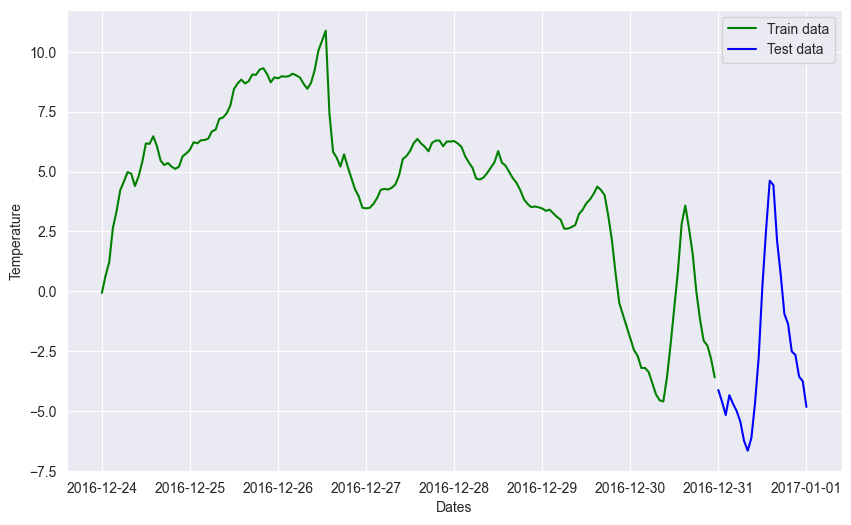

In [20]:
from sklearn.model_selection import train_test_split
train_data = df[(df.index.date>=date(2014,12,31))&(df.index.date<date(2016,12,31))][target]
test_data = df[df.index.date>=date(2016,12,31)][target]

print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Temperature')
plt.plot(train_data[-24*7:], 'green', label='Train data')
plt.plot(test_data[-24*7:], 'blue', label='Test data')
plt.legend()

# Treinando o SARIMA

In [ ]:
p, d, q = 2, 1, 1 # baseado na PACF, Dickey-Fuller e PACF
P, D, Q, s = 1, 1, 1, 24   # s=365 para dados diários com sazonalidade anual
model = SARIMAX(train_data, 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s),
                    )

sarima_result = model.fit(disp=False)
print(sarima_result.summary())

In [ ]:
test_forecast = sarima_result.get_forecast(steps=len(test_data.index))
forecast_ci = test_forecast.conf_int()

test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)

# Calculate the mean squared error
mae = mean_absolute_error(test_data, test_forecast_series)
mae

In [ ]:
# Plotando as previsões junto com a série original
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Série Original')
plt.plot(test_forecast.predicted_mean, label='Previsão SARIMA', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Série Temporal Horária com Previsões SARIMA (24 horas)")
plt.legend()
plt.show()

### Análise dos resíduos
Para o ARIMA, a normalidade dos resíduos é uma suposição importante para garantir que as inferências e previsões sejam confiáveis.

1. Pelo gráfico 1, os resíduos estão distribuidos ao redor de 0, sem tendência e tem uma variância uniforme. Isso significa que o modelo capturou alguma estrutura de dados.
2. Pelo gráfico 2, os resíduos estão normalmente distruibuidos ao redor de 0
3. O gráfico 3 pode indicar que o modelo não se ajustou perfeitamente, mas em geral, segue a linha
4. No gráfico 4, é possível ver que autocorrelação está em torno de 0, ou seja, não tem correlação temporal significativa.

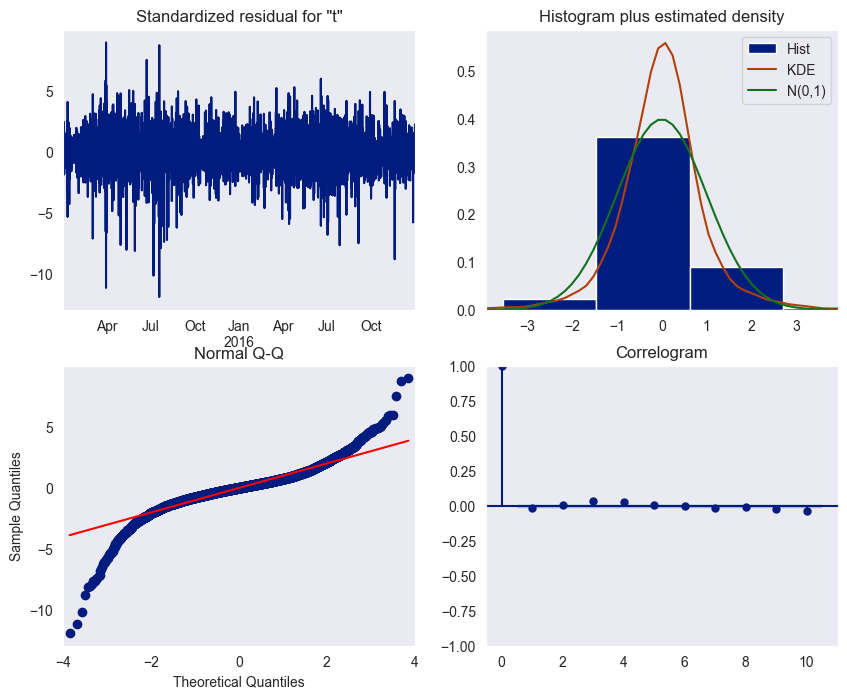

In [25]:
sarima_result.plot_diagnostics(figsize=(10,8))
plt.show()

# Walk Forward Validation

In [ ]:
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 24
lst_mae, y_pred_lst, y_true_lst = [], [], []
initial_params = sarima_result.params
n_samples = 60
current_train_end = date(2016,11,1)
test_end_date = date(2016,12,31)

while current_train_end <= test_end_date:
    train_data = df[(df.index.date>=date(2015,1,1))&(df.index.date<current_train_end)][target]
    test_data = df[df.index.date==current_train_end][target]
    # Build Model
    # Ajustando o modelo SARIMA
    model = SARIMAX(train_data, 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s),
                    )

    sarima_result = model.fit(disp=False, start_params=initial_params)
    test_forecast = sarima_result.get_forecast(steps=len(test_data.index))
    forecast_ci = test_forecast.conf_int()

    test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)
    y_pred_lst.append(test_forecast_series)
    y_true_lst.append(test_data)
    # Calculate the mean squared error
    mae = mean_absolute_error(test_data, test_forecast_series)
    lst_mae.append(mae)
    initial_params = sarima_result.params
    
    current_train_end = current_train_end + pd.Timedelta(days=1)
    print(f"MAE do dia {current_train_end}: {mae}")

MAE do dia 2016-11-02: 2.6427055346546844
MAE do dia 2016-11-03: 2.154156252263577
MAE do dia 2016-11-04: 1.2893940327891624
MAE do dia 2016-11-05: 0.7283763622551037
MAE do dia 2016-11-06: 1.3434622365484972
MAE do dia 2016-11-07: 1.3845982173052749
MAE do dia 2016-11-08: 2.222762969424235
MAE do dia 2016-11-09: 1.477314208480229
MAE do dia 2016-11-10: 0.9741452091186668
MAE do dia 2016-11-11: 0.9116436845580193
MAE do dia 2016-11-12: 1.582560836671471
MAE do dia 2016-11-13: 1.0971396652033907
MAE do dia 2016-11-14: 0.8675738475087478
MAE do dia 2016-11-15: 1.47583504014694
MAE do dia 2016-11-16: 2.500679319936305
MAE do dia 2016-11-17: 3.6319988542743755
MAE do dia 2016-11-18: 3.3646209330010706
MAE do dia 2016-11-19: 2.1632796407803436
MAE do dia 2016-11-20: 2.693828622316119
MAE do dia 2016-11-21: 2.8137081295875643
MAE do dia 2016-11-22: 0.8758380073138418
MAE do dia 2016-11-23: 1.0715072243435118
MAE do dia 2016-11-24: 0.9155566731292423
MAE do dia 2016-11-25: 1.7518614023638837


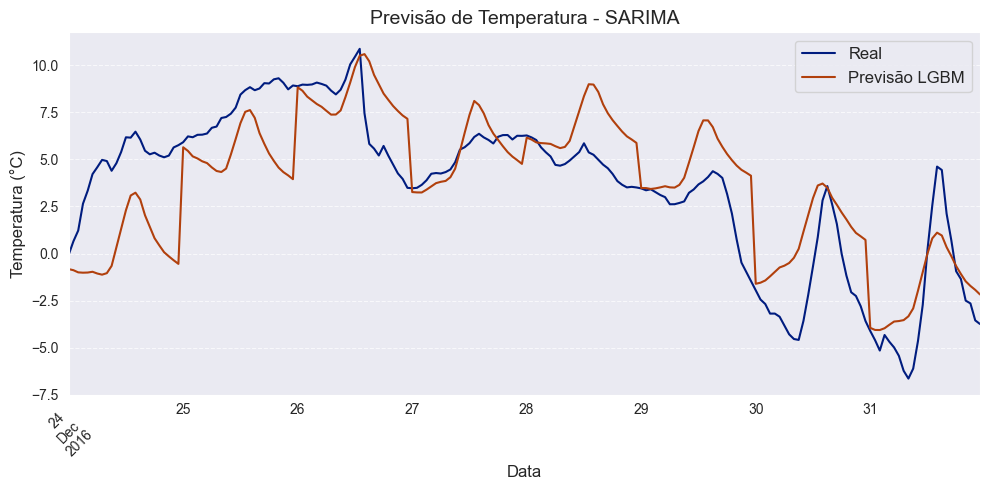

In [85]:
# Plotando as previsões junto com a série original
df_temp = pd.concat(y_true_lst).to_frame()
df_temp = pd.concat([df_temp, pd.concat(y_pred_lst).to_frame()],axis = 1)
df_temp = df_temp.sort_index()
legend_labels = ['Real', 'Previsão LGBM']
filter_start_date = date(2016, 12, 23)

plot_forecast(
    y_true=df_temp["temperature_celsius"],
    y_pred=df_temp["predicted_mean"],
    title='Previsão de Temperatura - SARIMA',
    filter_start_date=filter_start_date,
    xlabel='Data',
    ylabel='Temperatura (°C)',
    legend_labels=legend_labels
)

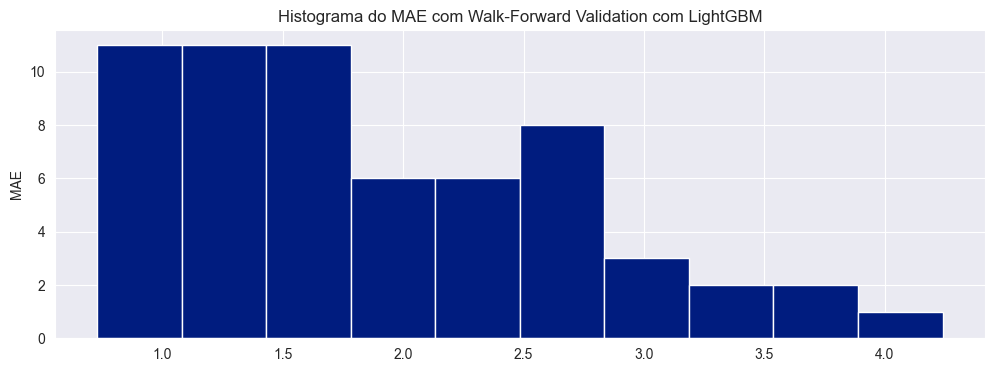

In [86]:
# # 3. Plotar a distribuição do MAE ao longo do tempo
plt.figure(figsize=(12, 4))
plt.hist(lst_mae)
# plt.xlabel('Data')
plt.ylabel('MAE')
plt.title('Histograma do MAE com Walk-Forward Validation com LightGBM')
plt.grid()
plt.show()

In [98]:
ic = calculate_ic(lst_mae, confidence=0.95)
# # Resultados
print(f"N samples: {len(lst_mae)}")
print(f"MAE médio: {np.mean(lst_mae):.4f}")
print(f"MAE desvio padrão: {np.std(lst_mae):.4f}")
print(f"Intervalo de Confiança de 95%: {ic}")

N samples: 61
MAE médio: 1.8911
MAE desvio padrão: 0.8273
Intervalo de Confiança de 95%: (1.68179503535286, 2.1004813760473673)


In [ ]:
pd.Series(lst_mae).to_csv("../data/lst_mae_sarima.csv")
df_temp.to_csv("../data/pred_sarima.csv")